In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from untitled import SM_World, plot_SM, plot_raster, make_dataset_first_gm, make_input_and_plot_sdist
from spikeship import spikeship
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, spectral_embedding, TSNE, Isomap

/gs/home/grimaldiav/.conda/envs_ppc/ppc-spikeship/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/mnt/pns/home/grimaldiav/Documents/SpikeShip/spikeship/spikeship.py:254: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(int32(int32, int32))


In [3]:
class world_params:
    N_pre = 100 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 3 # number of SM used for RP generation

    p_input = .05 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio)
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM

    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP

    avg_precision = 2 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision

    seed = 4815162342 # seed

In [24]:
def plot_embedding(embedding, labels, title, colors=['r','g','b']):
    fig, ax = plt.subplots(figsize=(10,5))
    for l in np.unique(labels[:,-1]):
        indices = labels[:,-1]==l
        if l<np.unique(labels[:,-1])[-1]:
            ax.scatter(embedding[indices,0], embedding[indices,1], facecolors=colors[int(l)])
        else:
            ax.scatter(embedding[indices,0], embedding[indices,1], facecolors=labels[indices,:3])
    ax.set_title(title);

## Model with 3 motifs and a combination of the 3

The mixture of the 3 kernels is given with a superposition of the kernels with coefficients between 0 and 1. They can be normalized to sum to 1 or not.

In [4]:
N_trials = 10
add_coef = torch.Tensor([.1,.7, .2])

In [5]:
opt = world_params()
world = SM_World(opt, add_coef = add_coef)
input_rp, labels = world.draw_input_one_sm(N_trials = N_trials)

/mnt/pns/home/grimaldiav/Documents/sms/generative_model/untitled.py:31: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch_1681837271882/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  self.kernels[-1, :, :] = torch.matmul(self.kernels.T,add_coef).T


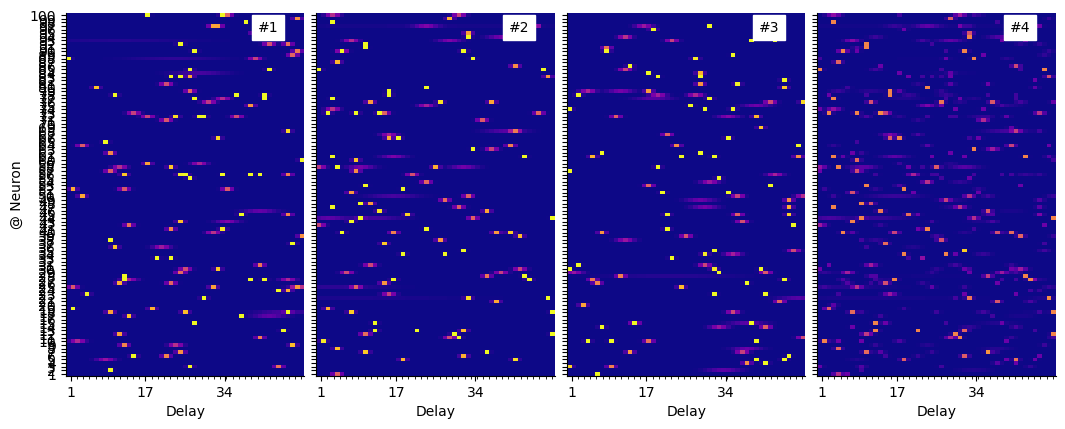

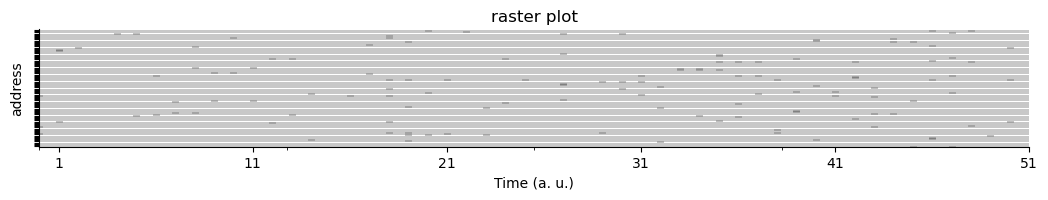

In [6]:
plot_SM(world.kernels, N_show = world.kernels.shape[0], figsize = (12, 5));
plot_raster(input_rp, colored=False);

### Format the ouput for SpikeShip

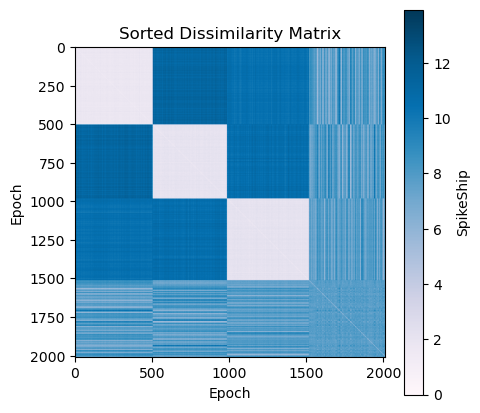

In [7]:
N_trials = 10
N_coef_changes = 200
normalize_coef = True
input_rp, labels, S_dist = make_input_and_plot_sdist(world, N_trials=N_trials, N_coef_changes=N_coef_changes, normalize_coef=normalize_coef)

## Manifold learning
### t-SNE

**From sklearn :** t-SNE (TSNE) converts affinities of data points to probabilities. The affinities in the original space are represented by Gaussian joint probabilities and the affinities in the embedded space are represented by Student’s t-distributions. This allows t-SNE to be particularly sensitive to local structure and has a few other advantages over existing techniques:

    Revealing the structure at many scales on a single map

    Revealing data that lie in multiple, different, manifolds or clusters

    Reducing the tendency to crowd points together at the center

While Isomap, LLE and variants are best suited to unfold a single continuous low dimensional manifold, t-SNE will focus on the local structure of the data and will tend to extract clustered local groups of samples as highlighted on the S-curve example. This ability to group samples based on the local structure might be beneficial to visually disentangle a dataset that comprises several manifolds at once as is the case in the digits dataset.

The Kullback-Leibler (KL) divergence of the joint probabilities in the original space and the embedded space will be minimized by gradient descent. Note that the KL divergence is not convex, i.e. multiple restarts with different initializations will end up in local minima of the KL divergence. Hence, it is sometimes useful to try different seeds and select the embedding with the lowest KL divergence.

The disadvantages to using t-SNE are roughly:

    t-SNE is computationally expensive, and can take several hours on million-sample datasets where PCA will finish in seconds or minutes

    The Barnes-Hut t-SNE method is limited to two or three dimensional embeddings.

    The algorithm is stochastic and multiple restarts with different seeds can yield different embeddings. However, it is perfectly legitimate to pick the embedding with the least error.

    Global structure is not explicitly preserved. This problem is mitigated by initializing points with PCA (using init='pca').


In [8]:
number_of_components = 2#len(world.add_coef)-1
colors = ['r', 'g', 'b']
print(f'expected number of components : {number_of_components}')

expected number of components : 2


Because we normalize the sum of mixture coefficients to be equal to 1, the problem can be solved with 2 components and we get a better visualization. 

In [27]:
%%time
tsne_embedding = TSNE(metric='precomputed', n_components=number_of_components, random_state=0, init='random').fit_transform(S_dist)

CPU times: user 2min 32s, sys: 956 ms, total: 2min 33s
Wall time: 6.6 s


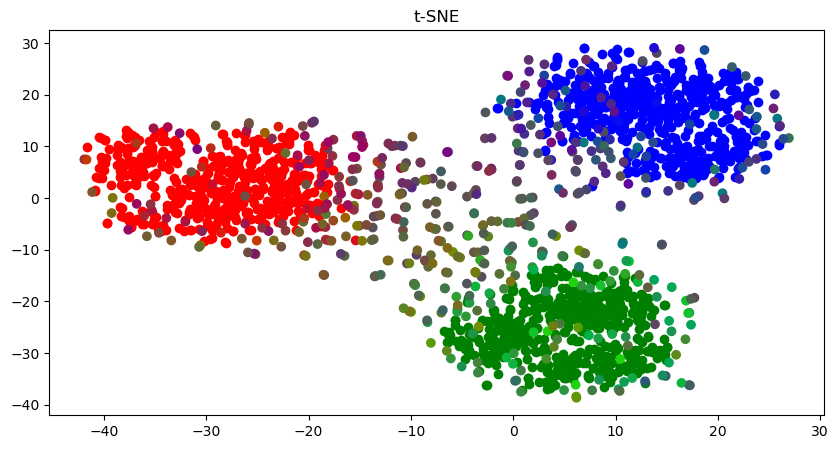

In [28]:
plot_embedding(tsne_embedding, labels, 't-SNE')

Isomap does not seem to be accurate at reducing the dimensionality. One can observe some color grading toward the different principal mixtures but there is a lot of noise in the mapping. 

Let's try to increase the perplexity (default=30)

In [29]:
tsne_embedding = TSNE(metric='precomputed', n_components=number_of_components, random_state=0, perplexity=300, init='random').fit_transform(S_dist)

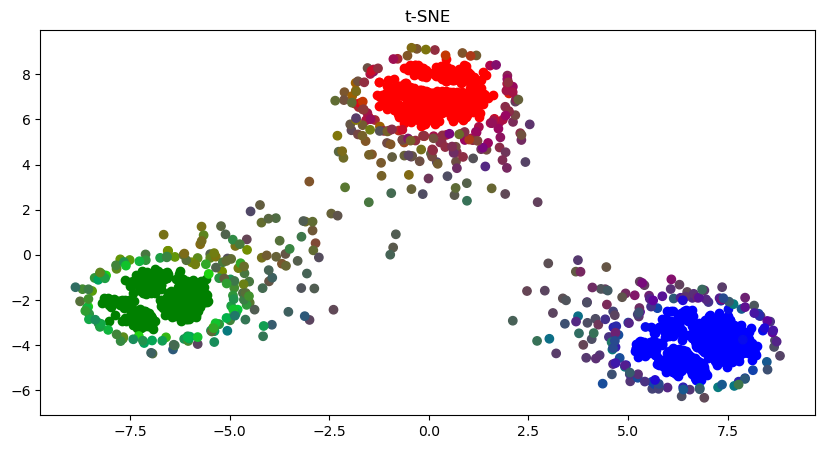

In [30]:
plot_embedding(tsne_embedding, labels, 't-SNE')

In [32]:
tsne_embedding = TSNE(metric='precomputed', n_components=number_of_components, random_state=0, perplexity=2000, init='random').fit_transform(S_dist)

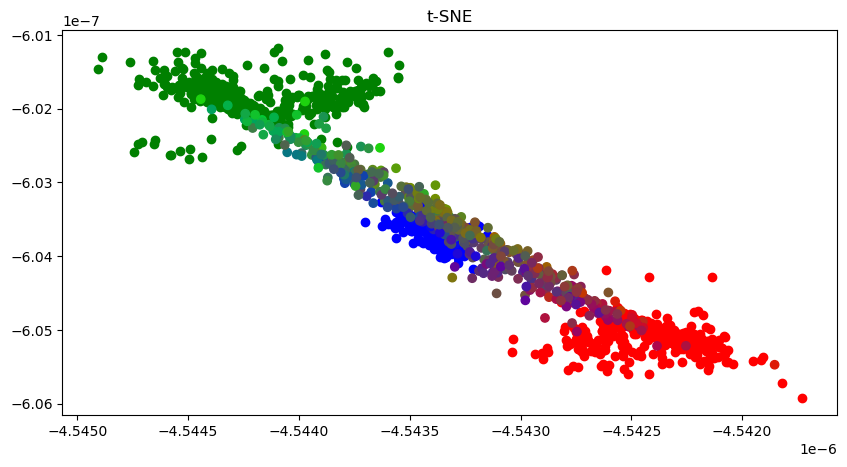

In [33]:
plot_embedding(tsne_embedding, labels, 't-SNE')

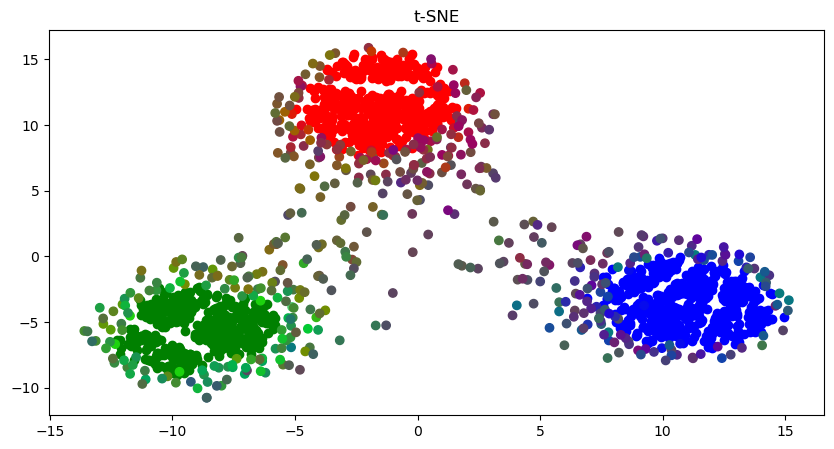

In [36]:
tsne_embedding = TSNE(metric='precomputed', n_components=number_of_components, random_state=0, perplexity=100, init='random').fit_transform(S_dist)
plot_embedding(tsne_embedding, labels, 't-SNE')

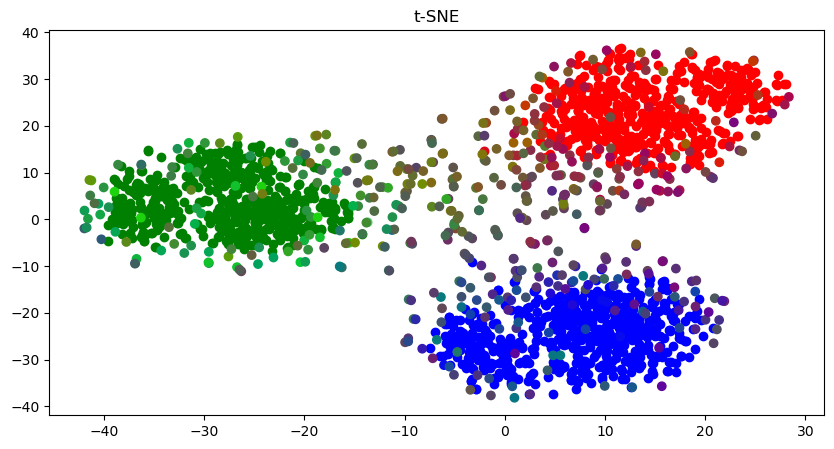

In [42]:
tsne_embedding = TSNE(metric='precomputed', n_components=number_of_components, early_exaggeration = 20, init='random').fit_transform(S_dist)
plot_embedding(tsne_embedding, labels, 't-SNE')

None of the parameter changing seem to efficiently solve the task. t-SNE may not be well-suited for this problem.